In [35]:
import warnings
warnings.filterwarnings('ignore')
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import  DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn import preprocessing
import seaborn as sb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 

Use Random Forest to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

In [2]:
fraudCheck_df = pd.read_csv('Fraud_check.csv')

EDA

In [3]:
fraudCheck_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


In [4]:
#Rename
fraudCheck_df.rename(columns={"Marital.Status":"MaritalStatus",
                              "Taxable.Income":"TaxableIncome",
                              "City.Population":"CityPopulation",
                              "Work.Experience":"WorkExperience"},inplace=True)

In [5]:
fraudCheck_df.duplicated().sum()

0

In [6]:
fraudCheck_df.corr(numeric_only=True)

,TaxableIncome,CityPopulation,WorkExperience
TaxableIncome,1.000000,-0.064387,-0.001818
CityPopulation,-0.064387,1.000000,0.013135
WorkExperience,-0.001818,0.013135,1.000000


<Axes: >

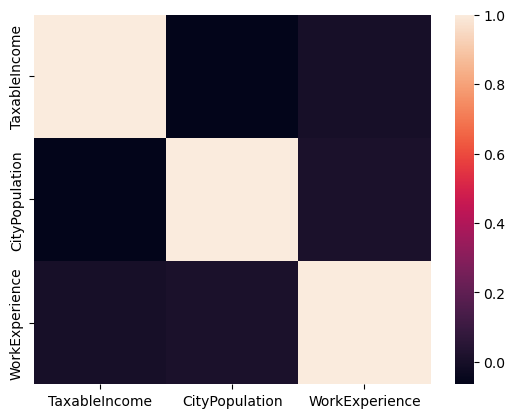

In [7]:
sb.heatmap(fraudCheck_df.corr(numeric_only=True))

TaxableIncome has negative correlation with population and experience.population and experience are having a positive correlation.

<Axes: >

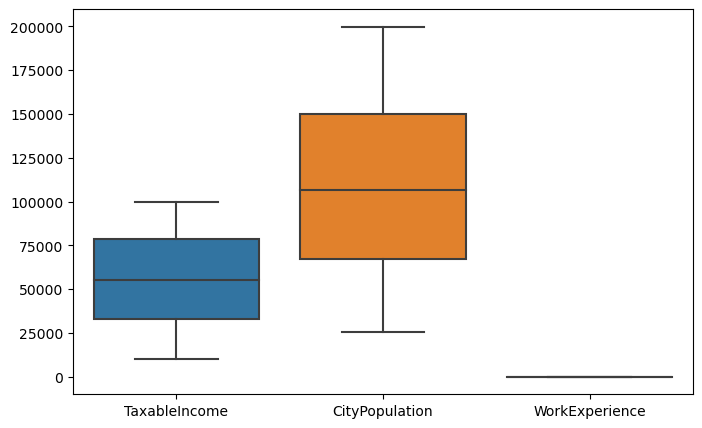

In [8]:
plt.figure(figsize=(8,5))
sb.boxplot(data=fraudCheck_df)

In [9]:
fraudCheck_df=pd.get_dummies(fraudCheck_df,columns=['Undergrad','MaritalStatus','Urban'], drop_first=True)

In [10]:
fraudCheck_df['Fraud'] = pd.cut(fraudCheck_df.TaxableIncome, bins=[10000,30000,99620],
                      labels=['Risky','Good'])
fraudCheck_df.head(5)

,TaxableIncome,CityPopulation,WorkExperience,Undergrad_YES,MaritalStatus_Married,MaritalStatus_Single,Urban_YES,Fraud
0,68833,50047,10,False,False,True,True,Good
1,33700,134075,18,True,False,False,True,Good
2,36925,160205,30,False,True,False,True,Good
3,50190,193264,15,True,False,True,True,Good
4,81002,27533,28,False,True,False,False,Good


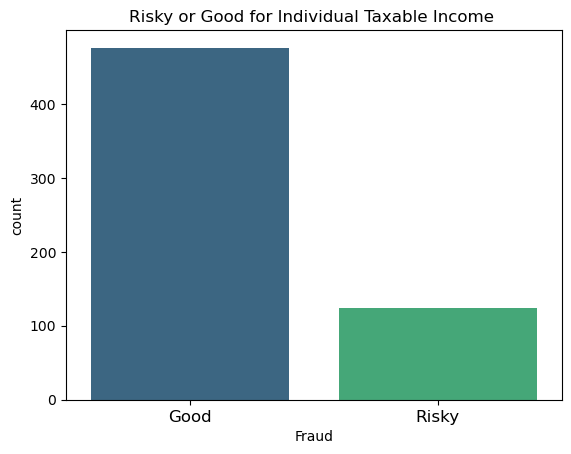

In [11]:
sb.countplot(x='Fraud', data= fraudCheck_df, palette = 'viridis', 
              order=fraudCheck_df['Fraud'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')
plt.show()

In [12]:
# Fraud chnage label data to numeric data
label_encoder = preprocessing.LabelEncoder()
fraudCheck_df['Fraud'] =  label_encoder.fit_transform(fraudCheck_df['Fraud'])

In [13]:
fraudCheck_df.head(5)

,TaxableIncome,CityPopulation,WorkExperience,Undergrad_YES,MaritalStatus_Married,MaritalStatus_Single,Urban_YES,Fraud
0,68833,50047,10,False,False,True,True,0
1,33700,134075,18,True,False,False,True,0
2,36925,160205,30,False,True,False,True,0
3,50190,193264,15,True,False,True,True,0
4,81002,27533,28,False,True,False,False,0


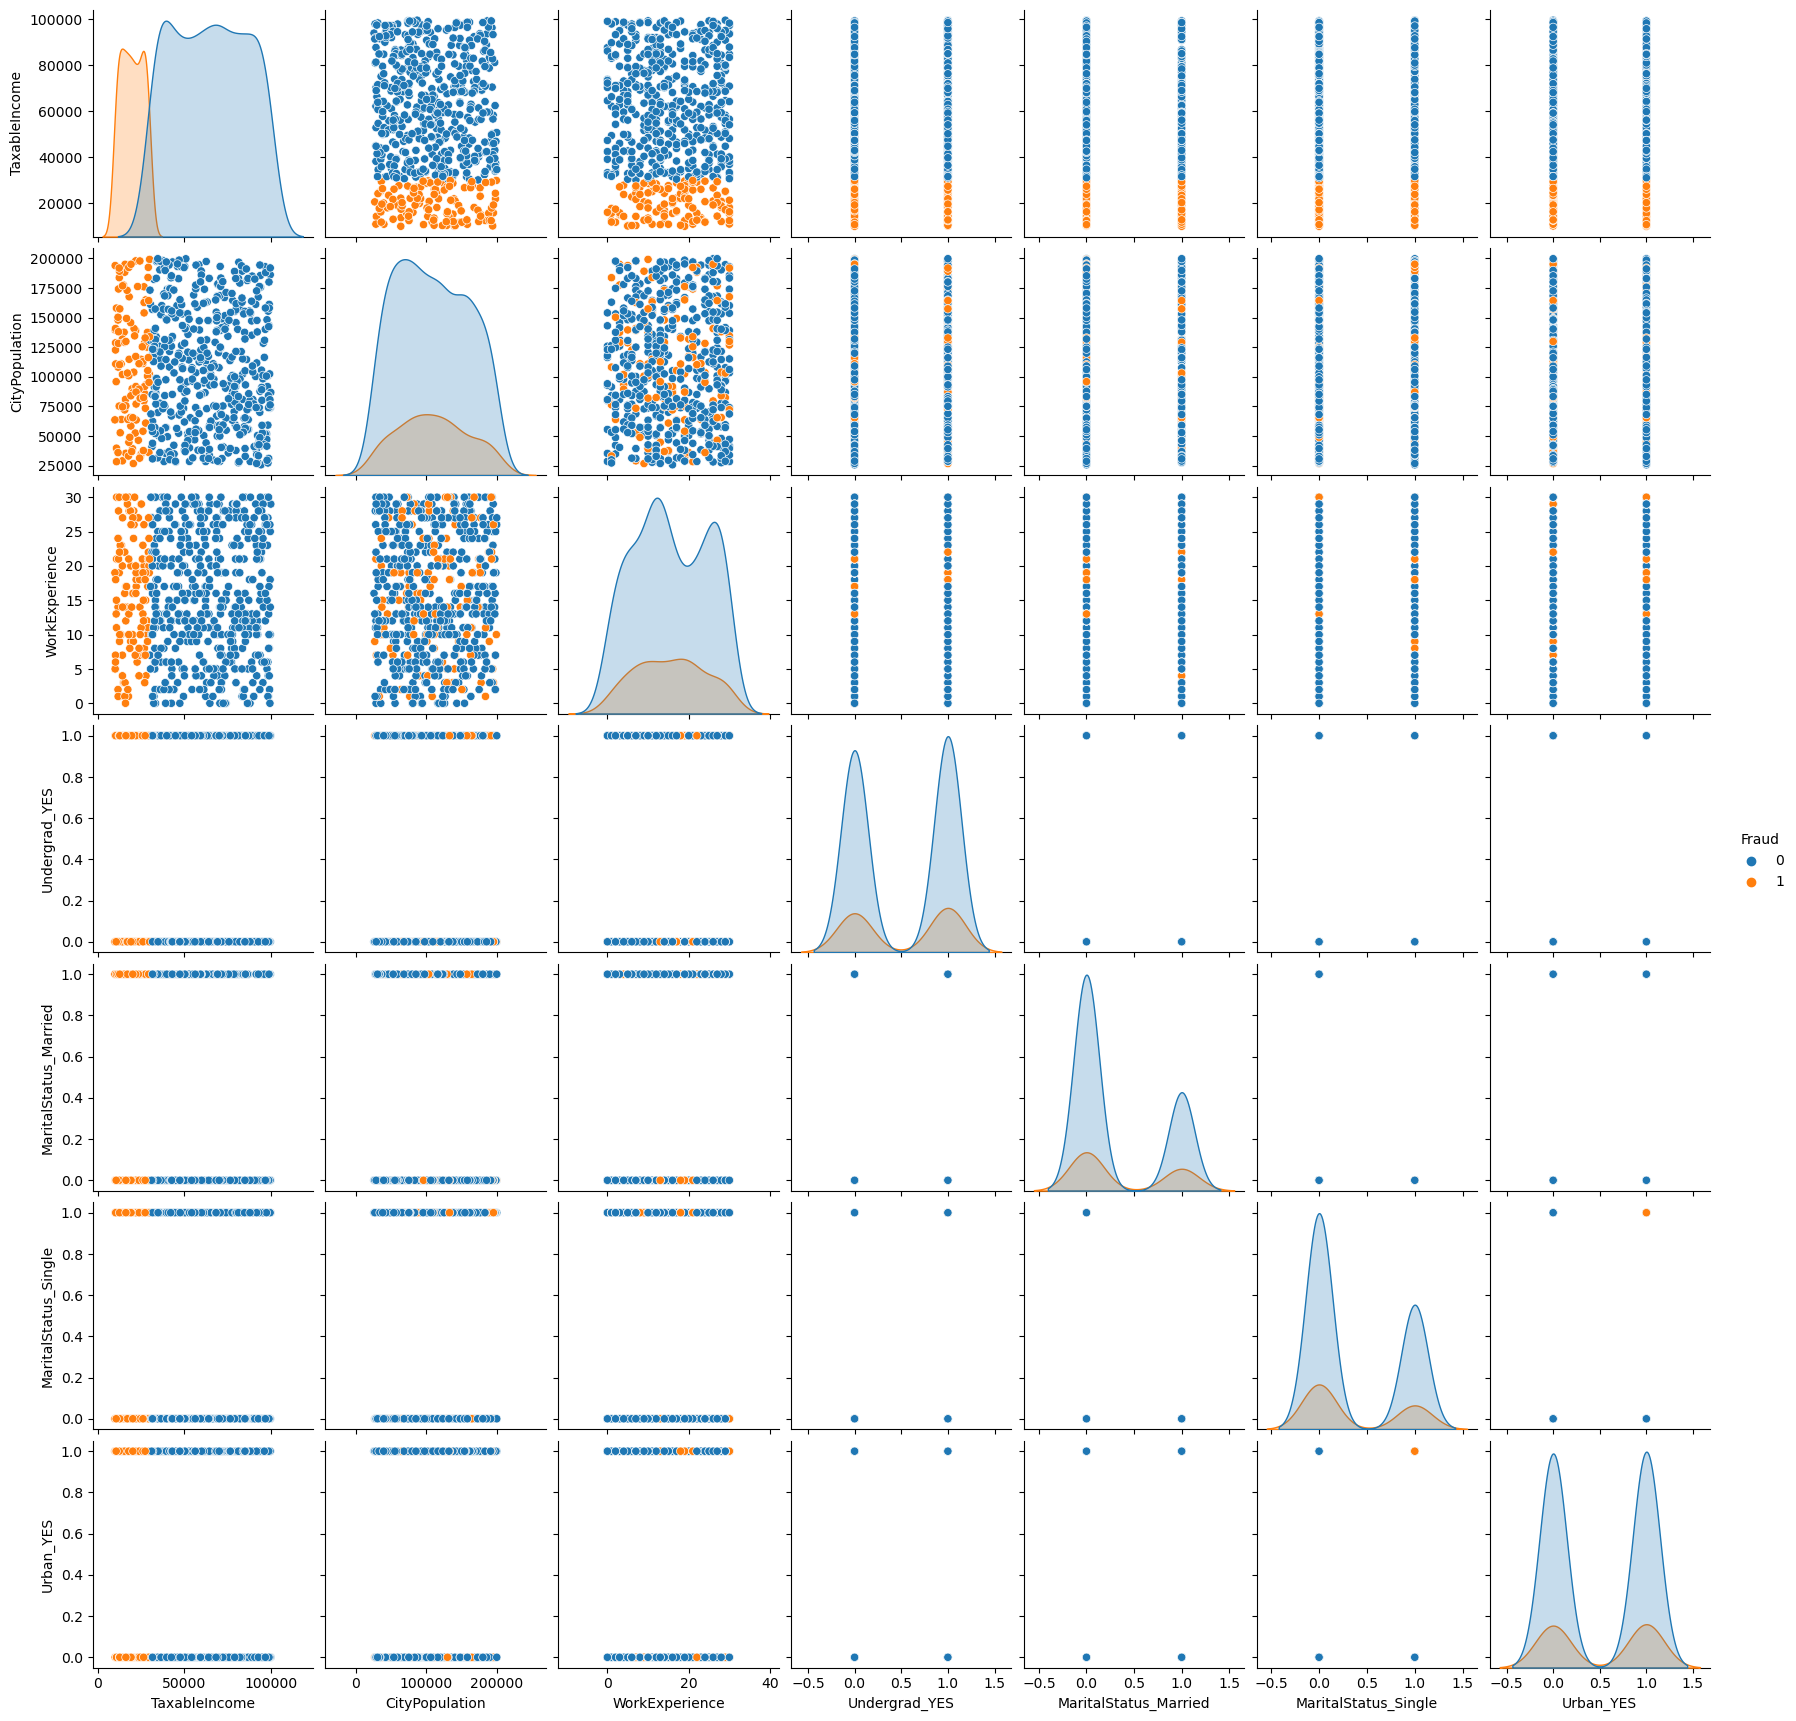

In [14]:
sb.pairplot(data=fraudCheck_df,hue="Fraud")

In [15]:
def norm_func(i):
    x = np.subtract(i,i.min(),dtype=np.float32)/ np.subtract(i.max(), i.min(),dtype=np.float32)
    return (x)

In [16]:
df_norm=fraudCheck_df
for col_names in fraudCheck_df.columns:
    df_norm[col_names] = norm_func(fraudCheck_df[col_names])


In [17]:
df_norm.head(2)

,TaxableIncome,CityPopulation,WorkExperience,Undergrad_YES,MaritalStatus_Married,MaritalStatus_Single,Urban_YES,Fraud
0,0.656468,0.139472,0.333333,0.0,0.0,1.0,1.0,0.0
1,0.264428,0.622394,0.600000,1.0,0.0,0.0,1.0,0.0


In [18]:
x=df_norm.drop(columns=['Fraud','TaxableIncome'],axis=1)
y=df_norm['Fraud']

In [19]:
# Splitting data into training and testing data set
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

Bagged DecisionTree

In [20]:
kfold = KFold(n_splits=10, random_state=42, shuffle = True)
cart = DecisionTreeClassifier()
num_trees = 500
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=42)
results = cross_val_score(model, x, y, cv=kfold)
print(results.mean())

0.7366666666666667


RandomForest

In [21]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

num_trees = 100
max_features = 3
kfold = KFold(n_splits=10, random_state=42, shuffle = True)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features, random_state=42)
results = cross_val_score(model, x, y, cv=kfold)
print(results.mean())

0.74


Hyperparameter turning

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'min_samples_leaf': [5,10,20,50,100,200],
              'max_leaf_nodes':randint(1,20),
              'criterion':['entropy','gini']
              
             }

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12d580850>,
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12de5de50>,
                                        'min_samples_leaf': [5, 10, 20, 50, 100,
                                                             200],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12df29fd0>})

In [23]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 17, 'max_leaf_nodes': 15, 'min_samples_leaf': 50, 'n_estimators': 349}


In [25]:
results = cross_val_score(best_rf, x_train, y_train, cv=kfold)
print(results.mean())

0.7928571428571429


In [36]:
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(x_train, y_train) 
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=25)


In [28]:
best_rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=17, max_leaf_nodes=15, min_samples_leaf=50,
                       n_estimators=349)

After Hyperparameter turning the model accuracy is better.

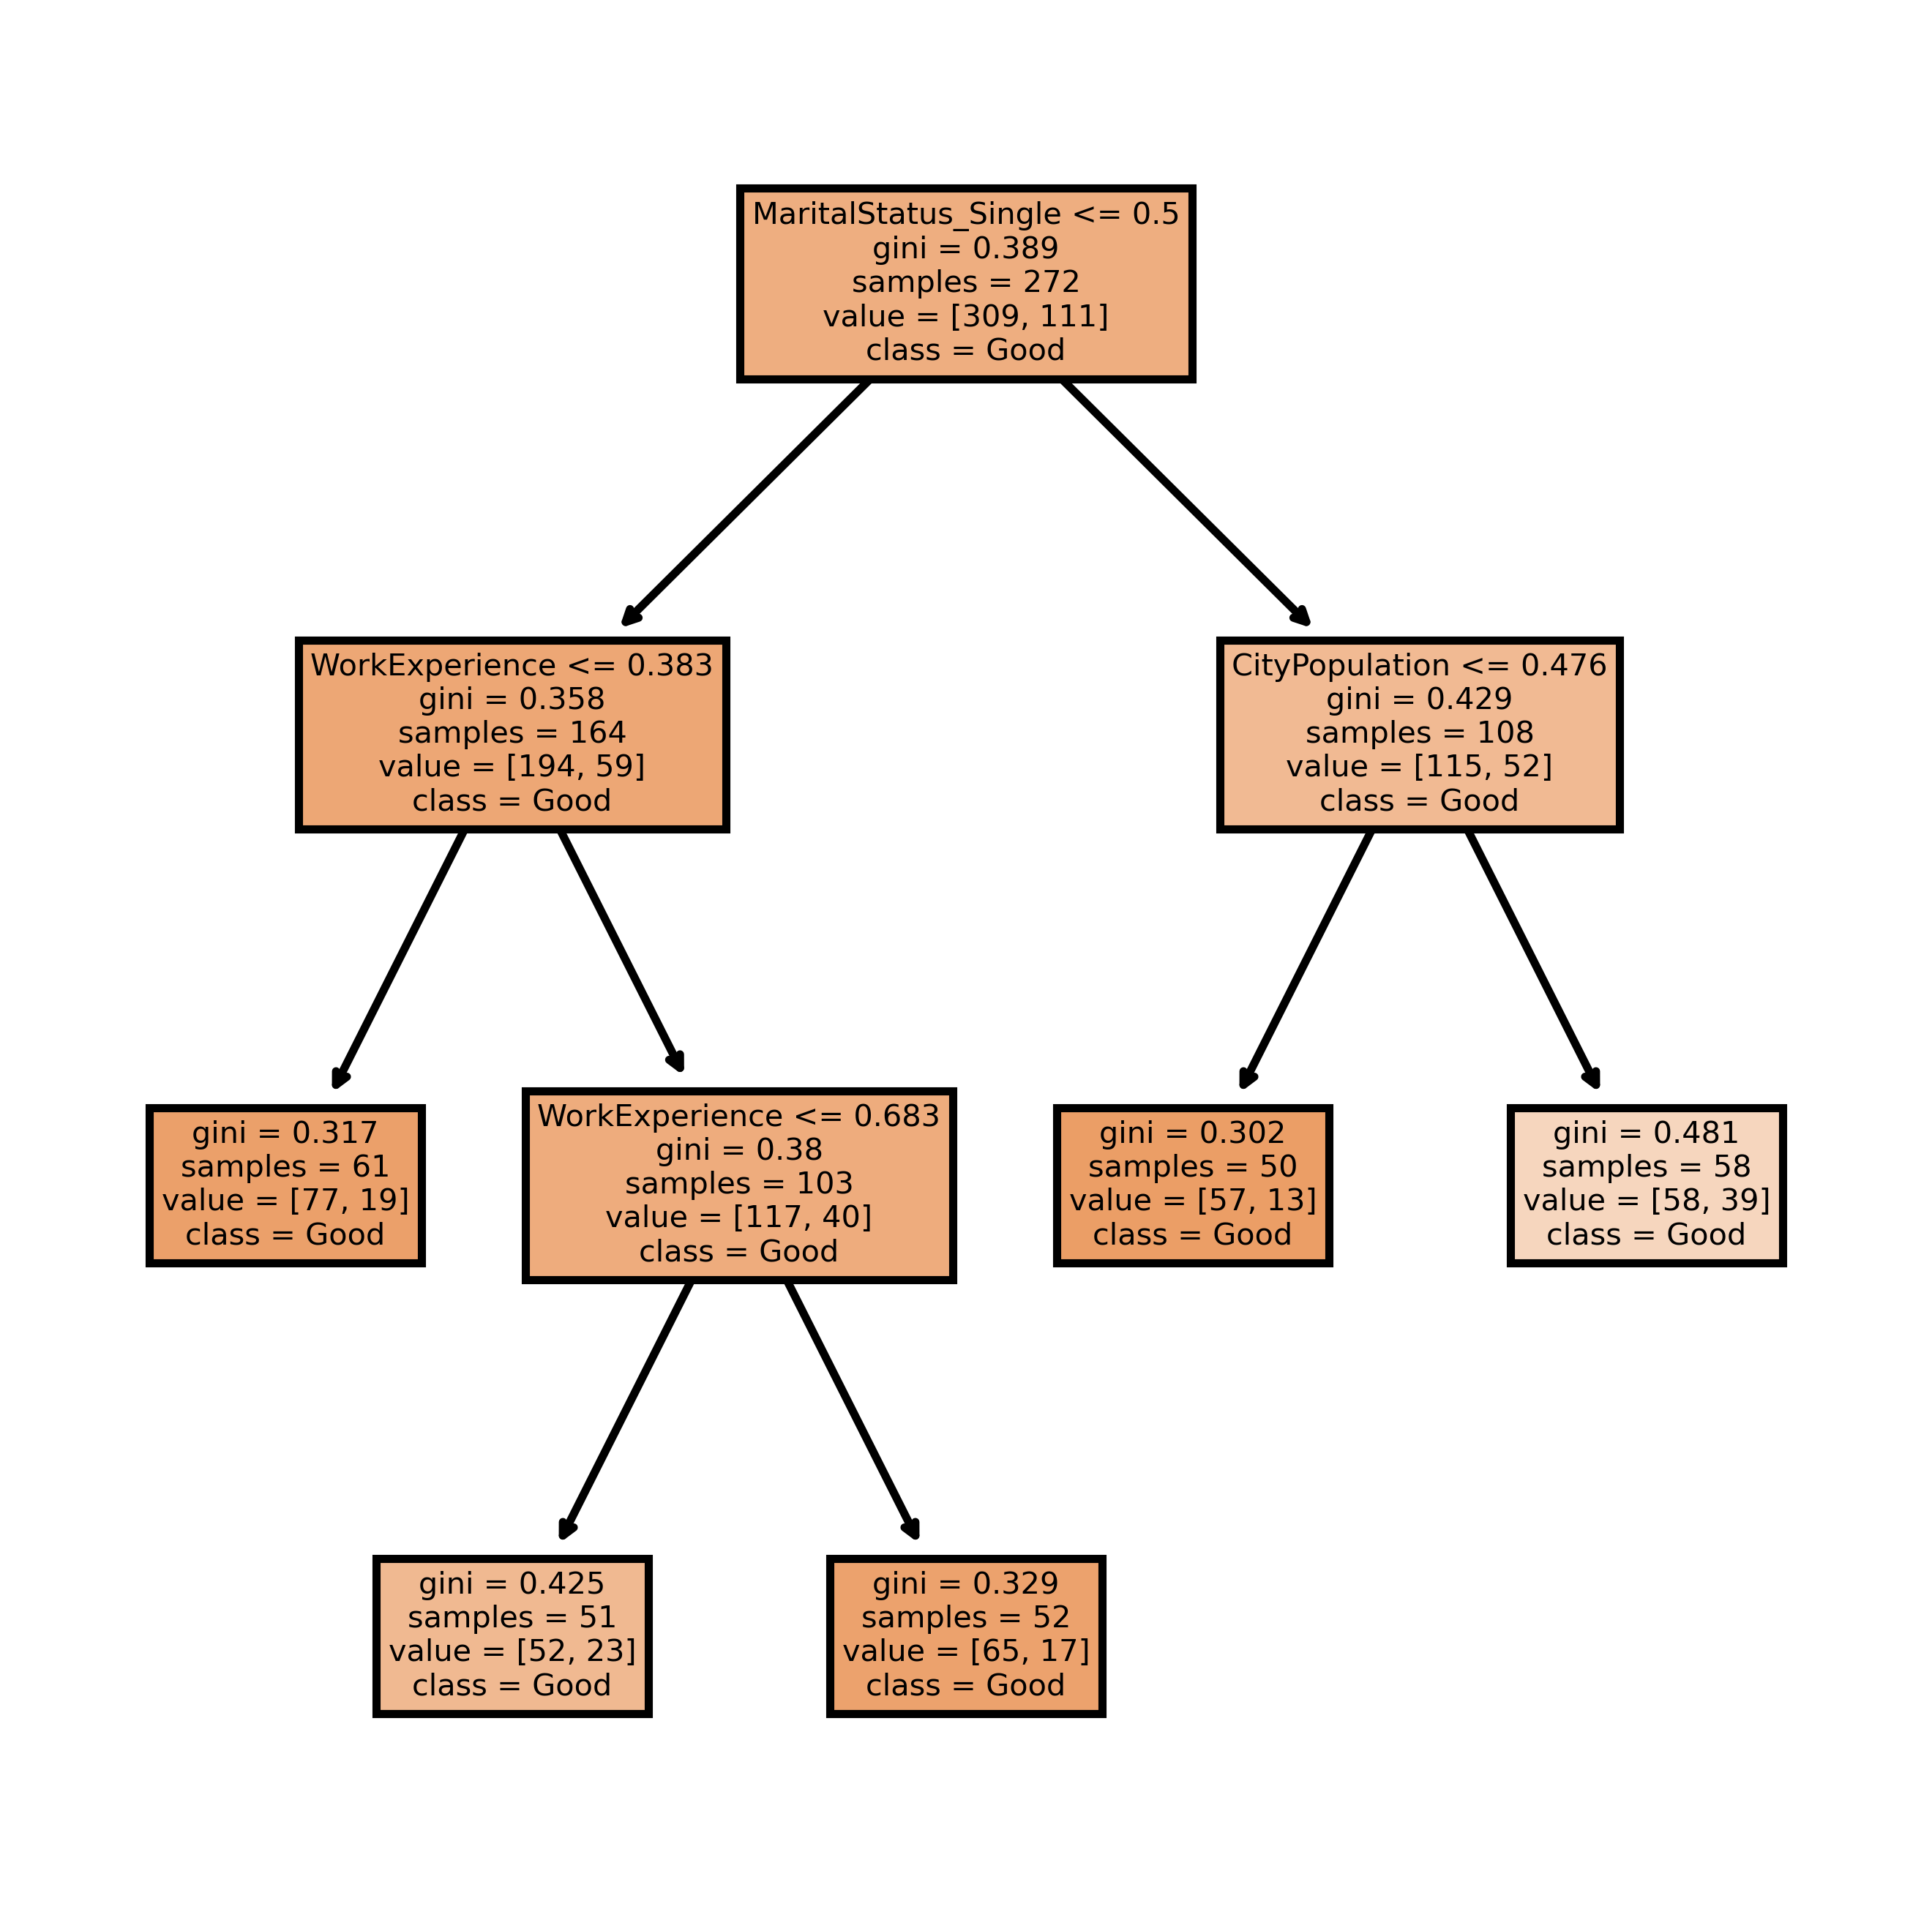

In [29]:
fn=x.columns.tolist()
cn=['Good','Risky']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(best_rf.estimators_[8],
               feature_names = fn, 
               class_names=cn,
               filled = True);

In [30]:
imp_df = pd.DataFrame({
    "Varname": x_train.columns,
    "Imp": model.feature_importances_
})

imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,CityPopulation,0.528007
1,WorkExperience,0.311132
5,Urban_YES,0.047867
2,Undergrad_YES,0.045958
3,MaritalStatus_Married,0.034805
4,MaritalStatus_Single,0.032230


In [32]:
y_pred_grid = best_rf.predict(x_test)
print(classification_report(y_pred_grid, y_test)) 

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.89       180
         1.0       0.00      0.00      0.00         0

    accuracy                           0.79       180
   macro avg       0.50      0.40      0.44       180
weighted avg       1.00      0.79      0.89       180



Boosting

In [31]:
from sklearn.ensemble import AdaBoostClassifier

num_trees = 437
kfold = KFold(n_splits=10, random_state=42, shuffle = True)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=42)
results = cross_val_score(model, x, y, cv=kfold)
print(results.mean())

0.7483333333333333
